In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../..")
from src.utils.constants import OPENPOSE_ANGLES

In [2]:
import warnings

warnings.filterwarnings(
    "ignore", category=FutureWarning, message=".*"
)

In [3]:
joints_squat_test_df = pd.read_csv("../../data/test/squat/joints.csv")
joints_squat_train_df = pd.read_csv("../../data/train/squat/joints.csv")

joints_df = pd.concat([joints_squat_train_df, joints_squat_test_df])

In [4]:
for _, rep in joints_df.groupby(["label", "rep"]):
    rep = rep.reset_index()
    if rep["label"].loc[0] == "correct":
        correct = rep
    else:
        incorrect = rep

In [5]:
from src.utils.data import joints_rep_df_to_numpy, get_angles_from_joints


correct_joints = joints_rep_df_to_numpy(correct)
correct_angles = get_angles_from_joints(correct_joints, OPENPOSE_ANGLES)

incorrect_joints = joints_rep_df_to_numpy(incorrect)
incorrect_angles = get_angles_from_joints(incorrect_joints, OPENPOSE_ANGLES)

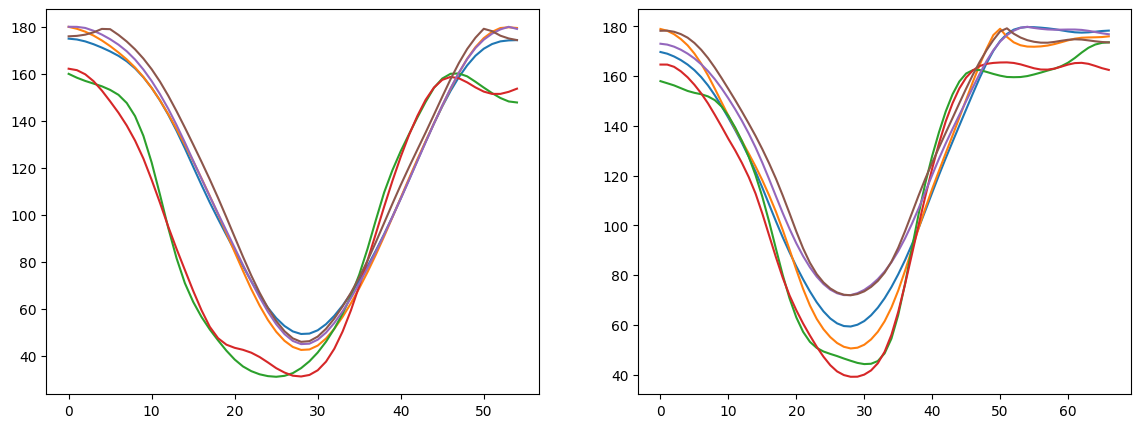

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].plot(correct_angles.values)
axes[1].plot(incorrect_angles.values);

In [7]:
rep_signal = correct_angles.mean(axis=1)
zero_point = np.mean(rep_signal)

In [8]:
def segment_signal(
    x: pd.DataFrame, important_angles: list[str], sliding_window_size: int = 5
) -> pd.DataFrame:
    x = x[important_angles]
    rep_signal = x.mean(axis=1)
    zero_point = np.mean(rep_signal)

    variances = []
    for idx in range(0, len(rep_signal) - sliding_window_size + 1, 1):
        window = rep_signal[idx : idx + sliding_window_size]
        variances.append(np.std(window))
    variances = np.array(variances)

    below_mean_indexes = np.where(rep_signal < zero_point)[0]
    above_mean_indexes = np.where(rep_signal > zero_point)[0]

    mid_phase_idx = (
        below_mean_indexes[np.argmin(variances[below_mean_indexes])]
        + sliding_window_size // 2
    )
    above_mean_indexes_left = above_mean_indexes[above_mean_indexes < mid_phase_idx]
    start_phase_idx = (
        above_mean_indexes_left[np.argmin(variances[above_mean_indexes_left])]
        + sliding_window_size // 2
    )

    above_mean_indexes_right = above_mean_indexes[above_mean_indexes > mid_phase_idx]
    above_mean_indexes_right = above_mean_indexes_right[
        above_mean_indexes_right < len(variances)
    ]
    finish_phase_idx = (
        above_mean_indexes_right[np.argmin(variances[above_mean_indexes_right])]
        + sliding_window_size // 2
    )
    return x.iloc[[start_phase_idx, mid_phase_idx, finish_phase_idx]]

In [9]:
import yaml

with open(f"../../configs/squat.yaml", "r") as file:
    file_data = yaml.safe_load(file)
    important_angles = file_data["important_angles"]
    reference_table = pd.DataFrame(file_data["reference_table"]).transpose()

In [10]:
phases_names = reference_table.index.values

In [11]:
phases = segment_signal(correct_angles, important_angles)

In [12]:
phases

,left_knee,right_knee,left_hip,right_hip
2,173.751412,177.886882,179.469794,176.618590
28,49.338613,42.554744,45.033318,45.996102
52,173.763923,179.438931,178.852210,176.182909


In [13]:
reference_table = reference_table.reset_index(drop=True)
reference_table

,left_knee,right_knee,left_hip,right_hip
0,175,175,175,175
1,55,55,40,40
2,175,175,175,175


In [14]:
phases = phases.reset_index(drop=True)
phases

,left_knee,right_knee,left_hip,right_hip
0,173.751412,177.886882,179.469794,176.618590
1,49.338613,42.554744,45.033318,45.996102
2,173.763923,179.438931,178.852210,176.182909


In [15]:
results = reference_table - phases

In [16]:
results

,left_knee,right_knee,left_hip,right_hip
0,1.248588,-2.886882,-4.469794,-1.618590
1,5.661387,12.445256,-5.033318,-5.996102
2,1.236077,-4.438931,-3.852210,-1.182909


In [17]:
results["phase"] = phases_names
results = results.set_index("phase")

In [18]:
results

,left_knee,right_knee,left_hip,right_hip
phase,,,,
start,1.248588,-2.886882,-4.469794,-1.618590
mid,5.661387,12.445256,-5.033318,-5.996102
finish,1.236077,-4.438931,-3.852210,-1.182909


In [19]:
from tslearn.metrics import dtw_path

reference = correct_angles["left_hip"]
query = incorrect_angles["left_hip"]

path, score = dtw_path(reference, query)
path = np.array(path)

In [20]:
reference_to_query = path[:, 0]
query_to_reference = path[:, 1]

In [21]:
def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

In [22]:
query_to_reference_idx = filter_repetable_reference_indexes(
    reference_to_query, query_to_reference
)
query_to_reference_warped = np.array([query[idx] for idx in query_to_reference_idx])

72.06314171684917

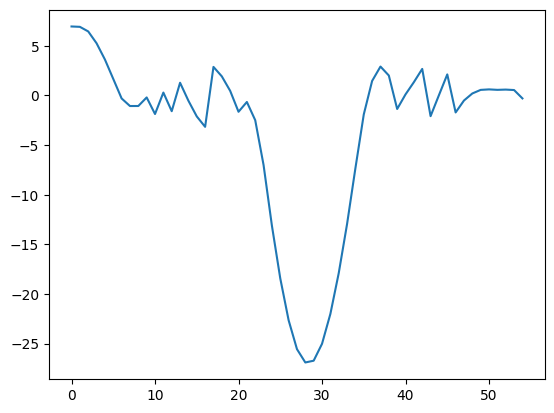

In [23]:
plt.plot(reference - query_to_reference_warped)
score

## statistical classification

In [24]:
from src.utils.data import calculate_3D_angle


angles_data = []
for (label, rep, frame), rep_data in joints_df.groupby(
    ["label", "rep", "frame"]
):
    rep_data = rep_data.reset_index()
    angles = {}
    for angle_name, angle_joints in OPENPOSE_ANGLES.items():
        joints_3d_positions = rep_data.loc[angle_joints][
            ["x", "y", "z"]
        ].astype("float")
        angles[angle_name] = calculate_3D_angle(*joints_3d_positions.values, by_axis="X")
    angles_data.append(
        pd.Series(
            {
                "rep": rep,
                "frame": frame,
                **angles,
                "label": label,
            }
        )
    )
angles_df = pd.DataFrame(angles_data)

In [25]:
with open(f"../../configs/squat.yaml", "r") as file:
    file_data = yaml.safe_load(file)
    important_angles = file_data["important_angles"]
    reference_table = pd.DataFrame(
        file_data["reference_table"]
    ).transpose()

In [26]:
from src.utils.data import segment_signal

def statistical_classification(
        query_angles: pd.DataFrame,
        reference_angles: pd.DataFrame,
        important_angles: dict,
        threshold: float = 20.
    ) -> bool:
    if len(phases_names) > 1:
        phases = segment_signal(query_angles, important_angles)
    else:
        phases = query_angles.loc[len(query_angles) // 2]
    phases = phases.reset_index(drop=True)
    results = reference_angles - phases
    results["phase"] = phases_names
    results = results.set_index("phase")

    for _, result in results.iterrows():
        wrong_angles = result.loc[result.abs() > threshold]
        if not wrong_angles.empty:
            return False

    return True

In [27]:
phases_names = reference_table.index.values
reference_angles = reference_table.reset_index(drop=True)

classification_results = []
y = []
for (label, rep), df in angles_df.groupby(["label", "rep"]):
    y.append(label)
    result = statistical_classification(df, reference_angles, important_angles)
    classification_results.append(result)

In [28]:
y = [1 if label == "correct" else 0 for label in y]
classification_results = [1 if label else 0 for label in classification_results]

In [29]:
_, class_counts = np.unique(y, return_counts=True)
class_counts = class_counts / len(y)
class_counts

array([0.68224299, 0.31775701])

In [30]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(y, classification_results))
print(accuracy_score(y, classification_results))
f1_score(y, classification_results)

              precision    recall  f1-score   support

           0       0.83      0.68      0.75        73
           1       0.51      0.71      0.59        34

    accuracy                           0.69       107
   macro avg       0.67      0.70      0.67       107
weighted avg       0.73      0.69      0.70       107

0.6915887850467289


0.5925925925925926